
Notebook chapter 04 

Autor Pedro Daia Cardoso

---








In [ ]:
# Exercício de treinamento, criacao de um modelo reconhecedor dos digitos 3 e 7

#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *
from fastai.vision.all import *

matplotlib.rc('image', cmap='Greys') # para mostrar tudo cinza os vetores

     |████████████████████████████████| 719 kB 26.5 MB/s 
     |████████████████████████████████| 4.4 MB 64.4 MB/s 
     |████████████████████████████████| 1.2 MB 66.5 MB/s 
     |████████████████████████████████| 362 kB 75.4 MB/s 
     |████████████████████████████████| 1.1 MB 30.9 MB/s 
     |████████████████████████████████| 101 kB 11.6 MB/s 
     |████████████████████████████████| 212 kB 77.3 MB/s 
     |████████████████████████████████| 140 kB 71.6 MB/s 
     |████████████████████████████████| 596 kB 62.4 MB/s 
     |████████████████████████████████| 127 kB 77.1 MB/s 
     |████████████████████████████████| 271 kB 73.0 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 144 kB 67.7 MB/s 
     |████████████████████████████████| 6.6 MB 51.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.1

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE) # esse sample do reconhecedor universal só tem 3s e 7s
Path.BASE_PATH = path
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()


Podemos criar um Pytorch tensor para representar a img, é um array do numpy injetavel na GPU
>`imgTensor = tensor(Image.open(threes[0]))`

In [ ]:
# Criar listas para guardar todos os setes e os tres
sevenTensors = [tensor(Image.open(i)) for i in sevens]
threeTensors = [tensor(Image.open(i)) for i in threes]

sevenStacked = torch.stack(sevenTensors).float() / 255 # divide por 255 pq imagem tem 255 pixels
threeStacked = torch.stack(threeTensors).float() / 255 # mas quando sao img como um float, valores de pixels sao entre 0 e 1


Como nos temos listas, não é util para fazer computacoes matematicas; já um tensor pode ter vários "eixos/dimensões", podemos pegar a lista de imgs e "stackar" uma em cima da outra criando uma espécie de cubo 3D, com o qual dá pra fazer os calculos

>## NOMENCLATURA IMPORTANTE 
>*   rank = dimensoes de um tensor
>*   shape = tamanho de cada dimensao


Precisamos medir proximidade de pixels (distância), para comparar os números com a média
> L2 Form: pega a MEAN do quadrado das diferencas e dps tira a raiz de tudo


 

In [ ]:
a = threeStacked[0] # vamos ver a distância desse 3 para a média do 3 e pro 7

distThree = ((a - threeStacked.mean(0))**2).mean().sqrt()
distSeven = ((a - sevenStacked.mean(0))**2).mean().sqrt()

if (distThree < distSeven):
  print('é um 3')
else: 
  print('é um 7')

é um 3


##Essa já é uma BASELINE válida para o modelo, é bem simples mas é sólida.

In [ ]:
# pegar a validation set
threeValidImg = (path/'valid'/'3').ls().sorted()
sevenValidImg = (path/'valid'/'7').ls().sorted()
threeValidationTensors = [tensor(Image.open(i)) for i in threeValidImg]
sevenValidationTensors = [tensor(Image.open(i)) for i in sevenValidImg]

threeStacked_validation = torch.stack(threeValidationTensors).float() / 255
sevenStacked_validation = torch.stack(sevenValidationTensors).float() / 255

def mnsit_dist(a, b):
  return ((a-b)**2).mean((-1,-2)).sqrt()
  #eixos -1 e -2 são os horizontal e vertical da img

`mnsit_dist(three_stackedValidation, stackedThrees.mean(0))` 

Essa chamada nao reclamaria de diferenca em shape, retornaria o calculo da dist para todos dentro do three_stackedValidation em relacao ao 3 ideal
>Nome disso é BROADCASTING, o pytorch altera o rank de um tensor para um cálculo com tensor de rank diferente

In [ ]:
def isThree(a):
  return mnsit_dist(a, threeStacked.mean(0)) < mnsit_dist(a, sevenStacked.mean(0))

# obs: ao converter bool return pra float, é 1.0 p true e 0.0 p false
# vamos calcular a accuracy, a precisão
acc_threes = isThree(threeStacked_validation).float().mean()
acc_sevens = 1 - (isThree(sevenStacked_validation).float().mean())
acc_threes, acc_sevens

(tensor(0.9584), tensor(0.9737))

####`(tensor(0.9584), tensor(0.9737))`
Este output indica uma precisão de 95% para os 3 e 97% para os 7 bom resultado mas são só 2 numeros, e sao bem diferentes, entao precisa melhorar muito

Percebe-se que o sistema ainda não tem uma capacidade de aprendizado, uma forma de alterar parâmetros para melhorar a performance, muito menos como medir algo do tipo.

>Ao invés de abordar pela Pixel Similarity, comparando uma img com uma "imagem ideal", podemos ter uma abordagem por "gradiente"
>Com o conceito de pesos, atribuímos pesos maiores a regiões de imagem mais prováveis para certo dígito, como por exemplo em um 7, a região inferior direita teria pesos menores pois é improvável, enquanto em um 8 a mesma região teria pesos maiores.


Por exemplo, uma função:
```
def pr_eight(x,w): return (x*w).sum()
```
onde *x* é a img, e *w* é um vetor de pesos

Ou seja, procurar pela melhor configuração do vetor *w* significa melhorar o reconhecimento do sistema.












#Cálculo de um gradiente



```
def f(x): return x**2

# requires_grad_()
# ^ ^ fc p dizer ao pytorch que quero calc grads nesse ponto c/ rel. a essa var
xTensor = tensor(3.).requires_grad_() 

yt = f(xTensor)
yt.backward()
xTensor.grad
```

>output

>```
tensor(6.)
```

Vamos então procurar uma funcao para aplicar o calculo do gradiente, funcao quadrática

In [ ]:
def f(t, params):
  a,b,c = params
  return a*(t**2) + b*t + c

def mse(preds, targets): return ((preds-targets)**2).mean()

Passos para o processo de Gradient Descent:

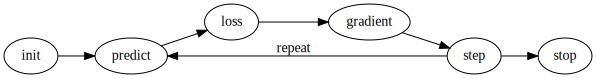

In [ ]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [ ]:
# -1 indica aumentar tamanho do eixo x o qto precisar, e 28*28 no y pois as imgs sao 28x28 px
train_x = torch.cat([threeStacked, sevenStacked]).view(-1, 28*28) # rank3 (lista de matrizes) para rank 2 (lista de vetores)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1) # labels 1 para 3s e 0 para 7s

# Criar um DataSet p/ o PyTorch, que tem que ser estrutura que quando buscar um index, retorna uma tuple
dset = list(zip(train_x, train_y))
#x,y = dset[0]
#x.shape, y # x=img(28*28 px), y=label(1=num3)

# repetir o mesmo para o validation set
validation_x = torch.cat([threeStacked_validation, sevenStacked_validation]).view(-1, 28*28) 
validation_y = tensor([1]*len(threeStacked_validation) + [0]*len(sevenStacked_validation)).unsqueeze(1)
validationDset = list(zip(validation_x , validation_y))

Agora devemos começar o primeiro passo do Gradient Descent

> initialize: atribuir, primeiramente de forma aleatória, pesos para cada pixel 



In [ ]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
weights = init_params((28*28,1))
# y = w*x + b
bias = init_params(1)



> y = w*x + b

####Em redes neurais, os pesos (w, weights) e o bias (b) juntos formam os parâmetros de um modelo.  

####Agora, calcularemos um chute inicial de parametros para as imagens. Vale a pena lembrar que não queremos utilizar um loop nativo do Python para iterar as imagens pois seria muito lento, então trabalharemos na GPU usando cálculo de multiplicaćão de matrizes para cada linha da matriz.

In [ ]:
#(train_x[0]*weights.T).sum() + bias # para 1 imagem
def matrixProduct(x_batch): return x_batch@weights + bias
chutes = matrixProduct(train_x)
chutes

tensor([[ -6.2330],
        [-10.6388],
        [-20.8865],
        ...,
        [-15.9176],
        [ -1.6866],
        [-11.3568]], grad_fn=<AddBackward0>)

In [ ]:
# checar accuracy
corretos = ((chutes > 0.0).float() == train_y).float().mean()
corretos

tensor(0.5380)

Precisamos de uma fc LOSS para calcular o gradiente.
Essa fc tem que ser de uma forma que, quando uma pequena mudanca nos pesos gerar uma pequena mudanca nos chutes, gere um loss um pouco "melhor".
Neste caso, um loss melhor seria gerado quando a fc retornar um score/confianca maior para um 3 (label y 1, mais prox. de 1), ou um score/confianca menor para um 7 (label y 0, mais prox. de 0)



*   Não utilizamos accuracy para cálculo da melhora.

ex:


```
labels          = tensor([1,0,1]) # um 3, um 7 e um 3 é o correto
chutes_results  = tensor([0.9, 0.4, 0.2])
# 0.9 = alta confianca que era um 3
# 0.4 = pouca confianca que era um 7
# 0.2 = alta confianca que era um 7, mas incorreto pois era um 3
```

se, no exemplo acima, chutes_results fosse [1,0,1] o loss seria [0, 0, 0], i.é


> quanto mais correto as predicoes/chutes, menor o loss.








In [ ]:
def mnist_loss(predictions, targets):
  predictions = predictions.sigmoid() ## .sigmoid() p/ garantir estarem todos entre 0 e 1
  return torch.where(targets==1, 1-predictions, predictions).mean()

Diferenca chave entre a métrica accuracy, e a fc loss: 


> metrics são para o entendimento humano, enquanto a fc loss é para o learning da rede neural, o processo automatizado.


> Dado isso, é importante saber que deve-se focar na MÉTRICA quando formos julgar a performance de um modelo.




Agora temos uma fc loss definida, precisamos de fazer o optimization step:  alterar os pesos com base nos gradientes.

Iterar todos os items calculando seu loss e as entao mudancas de peso seria muito demorado, então se utiliza um BATCH, i.e, somente um pedaco do total de items por vez para o cálculo, é um comprometimento de precisão porém poupa tempo. Logo, definir o BATCH SIZE é um ponto importante na criacao de modelos, onde um maior pode levar mais tempo para rodar cada epoch, porém gerando resultados melhores e vice-versa.


> PyTorch e o fastai providenciam uma classe para nós embaralharmos nossos itens a cada epoch e coletar uma mini-batch, a class *DataLoader*:



In [ ]:
# primeiro criar de ex. um Dataset de tuples (como nossos x_imgs e y_labels)
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [ ]:
dl = DataLoader(ds, batch_size=6, shuffle=True) # passamos o DataSet ao DataLoader
# isso vai criar então mini batches com todos os itens
list(dl)

[(tensor([19, 14,  0, 24, 20, 12]), ('t', 'o', 'a', 'y', 'u', 'm')),
 (tensor([23,  8,  9,  3, 16,  6]), ('x', 'i', 'j', 'd', 'q', 'g')),
 (tensor([ 4,  7,  1, 13,  2, 22]), ('e', 'h', 'b', 'n', 'c', 'w')),
 (tensor([ 5, 17, 18, 10, 11, 15]), ('f', 'r', 's', 'k', 'l', 'p')),
 (tensor([25, 21]), ('z', 'v'))]